# Imports and data loading

In [157]:
import glob
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import screed
import seaborn as sns
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm.auto import tqdm

import sourmash

tqdm.pandas()


from kmer_utils import get_encoded_kmer_hashvals

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
outdir = "/Users/olgabot/botryllus/adhoc-analysis/2022-apr--gather-botryllus-in-human-mouse-with-kmers/"
# ! mkdir $outdir

In [3]:
%%time

gather_results = pd.read_parquet(
    os.path.join(outdir, "botryllus_gather_mouse_human_results.parquet")
)

CPU times: user 34.5 s, sys: 39.3 s, total: 1min 13s
Wall time: 1min 19s


In [4]:
gather_results.head()

,i_query,kmer_query,kmer_hp,hashval,name_query,i_found,kmer_found,name_found,n_kmers,intersect_bp,containment,symbol,species,found_i,homolog_group,genomic_coord,all_homologs_found,transcript_id
0,150,YSFTLKDDTGEVVLDQWNKASLVP,hphphpppphphhhpphpphphhh,3018107519398277786,g25414.t1 frame:1,1238,PKISLRRSSLKYLGCRYSEIKPYG,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,0.011583,ASTN1,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7
1,151,SFTLKDDTGEVVLDQWNKASLVPG,phphpppphphhhpphpphphhhh,1234479950528962468,g25414.t1 frame:1,1239,KISLRRSSLKYLGCRYSEIKPYGL,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,0.011583,ASTN1,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7
2,152,FTLKDDTGEVVLDQWNKASLVPGK,hphpppphphhhpphpphphhhhp,2563348012698350512,g25414.t1 frame:1,1240,ISLRRSSLKYLGCRYSEIKPYGLD,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,0.011583,ASTN1,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7
3,15,NFHVGVKFVSSPKRGGVSQYLKGI,phphhhphhpphpphhhpphhphh,1046426320533182525,g25414.t1 frame:1,576,SVQPIVKLVSTATTAPPSTAPSGP,ENST00000453269.7 gene_id=ENSG00000106290.15;t...,2,10,0.015038,TAF6,human,1,TAF6---Taf6,Chr7:100107070-100119858(-),False,ENST00000453269.7
4,16,FHVGVKFVSSPKRGGVSQYLKGIF,hphhhphhpphpphhhpphhphhh,2154375574397474662,g25414.t1 frame:1,577,VQPIVKLVSTATTAPPSTAPSGPG,ENST00000453269.7 gene_id=ENSG00000106290.15;t...,2,10,0.015038,TAF6,human,1,TAF6---Taf6,Chr7:100107070-100119858(-),False,ENST00000453269.7


In [71]:
hashval_to_hp_kmer = pd.Series(
    dict(zip(gather_results["hashval"], gather_results["kmer_hp"]))
)
# hashval_to_hp_kmer.index = hashval_to_hp_kmer.index.astype(int)
print(hashval_to_hp_kmer.shape)
hashval_to_hp_kmer.drop_duplicates()
print(hashval_to_hp_kmer.shape)

(654467,)
(654467,)


In [68]:
hashval_to_hp_kmer

3018107519398277786    hphphpppphphhhpphpphphhh
1234479950528962468    phphpppphphhhpphpphphhhh
2563348012698350512    hphpppphphhhpphpphphhhhp
1046426320533182525    phphhhphhpphpphhhpphhphh
2154375574397474662    hphhhphhpphpphhhpphhphhh
                                 ...           
2741191184754143198    pphhhppphhhpppphhhhhppph
312706106409923617     phhhppphhhpppphhhhhppphp
5902042603803971015    hhhppphhhpppphhhhhppphph
2353047329972989606    phhpphhpphphpphpphhhpphp
1384586072134841031    hhpphhpphphpphpphhhpphpp
Length: 654467, dtype: object

In [ ]:
hp_kmer_counts = gather_results.kmer_hp.value_counts()
hp_kmer_counts.head()

pppppppppppppppppppppppp    11905648
hhhhhhhhhhhhhhhhhhhhhhhh      318655
hppppppppppppppppppppppp      167476
ppppppppppppppppppppppph      164949
pppppppppppppppppppppphp      118279
Name: kmer_hp, dtype: int64

In [ ]:
len(hp_kmer_counts)

656572

In [ ]:
hp_kmer_counts.tail()

hpppphpphhhphhhphphhhppp    1
pppphpphhhphhhphphhhppph    1
ppphpphhhphhhphphhhppphh    1
phhhphpphphhppppppphhpph    1
hhpphhpphphpphpphhhpphpp    1
Name: kmer_hp, dtype: int64

In [8]:
# sns.displot(hp_kmer_counts)

ERROR! Session/line number was not unique in database. History logging moved to new session 267


# Get signature files

In [9]:
botryllus_dir = "/Users/olgabot/botryllus/data/botryllus-proteins/"

human_gencode_dir = "/Users/olgabot/botryllus/data/gencode/v38/"
mouse_gencode_dir = "/Users/olgabot/botryllus/data/gencode/M28/"

## set signature files

human_sigfile = os.path.join(
    human_gencode_dir, "gencode.v38.basic.annotation.protein.fa.hp.k24.scale5.sig"
)
mouse_sigfile = os.path.join(
    mouse_gencode_dir, "gencode.vM28.basic.annotation.protein.fa.hp.k24.scale5.sig"
)

botryllus_sigfile = os.path.join(botryllus_dir, "Bs_proteins.fa.hp.k24.scale5.sig")

## Create non-singleton sourmash sketch

In [47]:
human_fasta = os.path.join(human_gencode_dir, "gencode.v38.basic.annotation.protein.fa")
human_sigfile_aggregated = os.path.join(
    human_gencode_dir,
    "gencode.v38.basic.annotation.protein.fa.hp.k24.scale5.aggregated.sig",
)
! time sourmash sketch protein --output $human_sigfile_aggregated --hp -p k=24,scaled=5,abund $human_fasta


== This is sourmash version 4.4.0. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

computing signatures for files: /Users/olgabot/botryllus/data/gencode/v38/gencode.v38.basic.annotation.protein.fa
Computing a total of 1 signature(s) for each input.
... reading sequences from /Users/olgabot/botryllus/data/gencode/v38/gencode.v38.basic.annotation.protein.fa
calculated 1 signatures for 61543 sequences in /Users/olgabot/botryllus/data/gencode/v38/gencode.v38.basic.annotation.protein.fa
saved 1 signature(s) to '/Users/olgabot/botryllus/data/gencode/v38/gencode.v38.basic.annotation.protein.fa.hp.k24.scale5.aggregated.sig'. Note: signature license is CC0.
sourmash sketch protein --output  --hp -p k=24,scaled=5,abund   549.77s user 4.74s system 99% cpu 9:17.51 total


## Aggregate k-mer signature in botryllus. I guess I could have just re-made the signature without `--singleton`

In [42]:
for i, sig in tqdm(enumerate(sourmash.load_file_as_signatures(botryllus_sigfile))):
    if i == 0:
        # Initialize the minhash object
        aggregated_mh = sourmash.MinHash(
            sig.minhash.num,
            sig.minhash.ksize,
            is_protein=sig.minhash.is_protein,
            dayhoff=sig.minhash.dayhoff,
            hp=sig.minhash.hp,
            track_abundance=sig.minhash.track_abundance,
            seed=sig.minhash.seed,
            max_hash=sig.minhash._max_hash,
        )

    aggregated_mh.merge(sig.minhash)
    # for hashval, abundance in sig.minhash.hashes.items():
    #     aggregated_mh.add_hash_with_abundance(hashval, abundance)

72617it [06:32, 184.86it/s] 


In [43]:
len(aggregated_mh.hashes)

1499641

In [ ]:
aggregated_mh

In [44]:
# hashes = pd.Series(aggregated_mh.hashes)
# hashes[hashes > 1]

In [45]:
len(sig.minhash.hashes)

12

In [48]:
human_sig = sourmash.load_one_signature(human_sigfile_aggregated)

In [49]:
len(human_sig.minhash.hashes)

1521355

### Read botryllus kmer hashes

In [127]:
def read_hash_csv(csv):
    df = pd.read_csv(csv)

    # Force hashval to be strings to avoid overflow/underflow errors
    df["hashval"] = df["hashval"].astype(str)
    df = df.set_index(["hashval"])
    return df

In [128]:
csv = os.path.join(botryllus_dir, "Bs_proteins.fa.hp.k24.scale5.aggregated.kmers.csv")
botryllus_kmer_hashes = read_hash_csv(csv)
# botryllus_kmer_hashes.index = botryllus_kmer_hashes.index.astype(str)
botryllus_kmer_hashes

,kmer_in_sequence,kmer_in_alphabet,read_name,filename
hashval,,,,
1036020595944595459,VHDTEQLLAQGHHEEETECGKYGK,hppppphhhphpppppppphphhp,BHF,Bs_proteins.fa.gz
2993707203445337902,TEQLLAQGHHEEETECGKYGKLPE,ppphhhphpppppppphphhphhp,BHF,Bs_proteins.fa.gz
973051056292048589,EQLLAQGHHEEETECGKYGKLPEK,pphhhphpppppppphphhphhpp,BHF,Bs_proteins.fa.gz
385192726330471768,ETECGKYGKLPEKGSECKKHGIFC,pppphphhphhpphpppppphhhp,BHF,Bs_proteins.fa.gz
1194029314525711201,KYGKLPEKGSECKKHGIFCRILTA,phhphhpphpppppphhhpphhph,BHF,Bs_proteins.fa.gz
...,...,...,...,...
1833930335722081195,LEREIEAQQLVMLEAEIDCLQRRF,hppphphpphhhhphphpphppph,g72096.t1 frame:1,Bs_proteins.fa.gz
616964295969867237,EREIEAQQLVMLEAEIDCLQRRFE,ppphphpphhhhphphpphppphp,g72096.t1 frame:1,Bs_proteins.fa.gz
1869927996039995699,MLEAEIDCLQRRFEDMESTWISRI,hhphphpphppphpphppphhpph,g72096.t1 frame:1,Bs_proteins.fa.gz


In [129]:
botryllus_kmer_hashes.head().index

Index(['1036020595944595459', '2993707203445337902', '973051056292048589',
       '385192726330471768', '1194029314525711201'],
      dtype='object', name='hashval')

In [130]:
human_gencode_dir = "/Users/olgabot/botryllus/data/gencode/v38/"
mouse_gencode_dir = "/Users/olgabot/botryllus/data/gencode/M28/"
human_kmers_csv = os.path.join(
    human_gencode_dir,
    "gencode.v38.basic.annotation.protein.fa.hp.k24.scale5.aggregated.kmers.csv",
)

human_kmer_hashes = read_hash_csv(human_kmers_csv)
# human_kmer_hashes.index = human_kmer_hashes.index.astype(str)
human_kmer_hashes

,kmer_in_sequence,kmer_in_alphabet,read_name,filename
hashval,,,,
3438741737707008236,AEAISWNESTSETNNSMVTEFIFL,hphhphpppppppppphhpphhhh,ENST00000641515.2 gene_id=ENSG00000186092.7;tr...,/Users/olgabot/botryllus/data/gencode/v38/genc...
2304868333845493775,SWNESTSETNNSMVTEFIFLGLSD,phpppppppppphhpphhhhhhpp,ENST00000641515.2 gene_id=ENSG00000186092.7;tr...,/Users/olgabot/botryllus/data/gencode/v38/genc...
773785692324772595,ETNNSMVTEFIFLGLSDSQELQTF,ppppphhpphhhhhhppppphpph,ENST00000641515.2 gene_id=ENSG00000186092.7;tr...,/Users/olgabot/botryllus/data/gencode/v38/genc...
2297609714666314612,TNNSMVTEFIFLGLSDSQELQTFL,pppphhpphhhhhhppppphpphh,ENST00000641515.2 gene_id=ENSG00000186092.7;tr...,/Users/olgabot/botryllus/data/gencode/v38/genc...
1737326980818371865,NNSMVTEFIFLGLSDSQELQTFLF,ppphhpphhhhhhppppphpphhh,ENST00000641515.2 gene_id=ENSG00000186092.7;tr...,/Users/olgabot/botryllus/data/gencode/v38/genc...
...,...,...,...,...
963288537120590718,NIVPIAILVFAACEAAVGLALLVS,phhhhhhhhhhhpphhhhhhhhhp,ENST00000361335.1 gene_id=ENSG00000212907.2;tr...,/Users/olgabot/botryllus/data/gencode/v38/genc...
1219365156401211377,AACEAAVGLALLVSISNTYGLDYV,hhpphhhhhhhhhphppphhhphh,ENST00000361335.1 gene_id=ENSG00000212907.2;tr...,/Users/olgabot/botryllus/data/gencode/v38/genc...
3243920481552129892,CEAAVGLALLVSISNTYGLDYVHN,pphhhhhhhhhphppphhhphhpp,ENST00000361335.1 gene_id=ENSG00000212907.2;tr...,/Users/olgabot/botryllus/data/gencode/v38/genc...


# Make pandas series of hashes

In [110]:
%%time
human_minhashes = pd.Series(human_sig.minhash.hashes, name="human")
human_minhashes.index = human_minhashes.index.astype(str)

CPU times: user 2.63 s, sys: 248 ms, total: 2.88 s
Wall time: 2.96 s


In [111]:
human_minhashes.describe()

count    1.521355e+06
mean     4.074873e+00
std      7.673557e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      5.000000e+00
max      7.222000e+03
Name: human, dtype: float64

In [112]:
%%time
botryllus_minhashes = pd.Series(aggregated_mh.hashes)
botryllus_minhashes.index = botryllus_minhashes.index.astype(str)

CPU times: user 2.58 s, sys: 240 ms, total: 2.82 s
Wall time: 2.96 s


In [113]:
botryllus_minhashes.describe()

count    1.499641e+06
mean     2.041660e+00
std      3.646242e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.535000e+03
dtype: float64

In [114]:
botryllus_kmer_hashes

,,kmer_in_sequence,read_name,filename
hashval,kmer_in_alphabet,,,
1036020595944595459,hppppphhhphpppppppphphhp,VHDTEQLLAQGHHEEETECGKYGK,BHF,Bs_proteins.fa.gz
2993707203445337902,ppphhhphpppppppphphhphhp,TEQLLAQGHHEEETECGKYGKLPE,BHF,Bs_proteins.fa.gz
973051056292048589,pphhhphpppppppphphhphhpp,EQLLAQGHHEEETECGKYGKLPEK,BHF,Bs_proteins.fa.gz
385192726330471768,pppphphhphhpphpppppphhhp,ETECGKYGKLPEKGSECKKHGIFC,BHF,Bs_proteins.fa.gz
1194029314525711201,phhphhpphpppppphhhpphhph,KYGKLPEKGSECKKHGIFCRILTA,BHF,Bs_proteins.fa.gz
...,...,...,...,...
1833930335722081195,hppphphpphhhhphphpphppph,LEREIEAQQLVMLEAEIDCLQRRF,g72096.t1 frame:1,Bs_proteins.fa.gz
616964295969867237,ppphphpphhhhphphpphppphp,EREIEAQQLVMLEAEIDCLQRRFE,g72096.t1 frame:1,Bs_proteins.fa.gz
1869927996039995699,hhphphpphppphpphppphhpph,MLEAEIDCLQRRFEDMESTWISRI,g72096.t1 frame:1,Bs_proteins.fa.gz


In [115]:
botryllus_minhashes_freq = botryllus_minhashes / botryllus_minhashes.sum()
human_minhashes_freq = human_minhashes / human_minhashes.sum()

In [116]:
botryllus_minhashes_freq.describe()

count    1.499641e+06
mean     6.668263e-07
std      1.190899e-06
min      3.266099e-07
25%      3.266099e-07
50%      3.266099e-07
75%      6.532197e-07
max      5.013461e-04
dtype: float64

In [117]:
human_minhashes_freq.describe()

count    1.521355e+06
mean     6.573088e-07
std      1.237804e-06
min      1.613078e-07
25%      3.226156e-07
50%      4.839233e-07
75%      8.065389e-07
max      1.164965e-03
Name: human, dtype: float64

### What's the minimum probability of overlap between two k-mers?

In [249]:
human_minhashes_freq.min() * botryllus_minhashes_freq.min()

5.2684710199159876e-14

### What's the MAXimum probability of overlap between two k-mers?

In [250]:
human_minhashes_freq.max() * botryllus_minhashes_freq.max()

5.840505797845405e-07

In [118]:
human_minhashes_freq[human_minhashes_freq > 1e-4]

248203946111836632     0.000128
853878169790340257     0.001165
1176596621400818277    0.000150
2621898202634985687    0.000101
3640030393541500537    0.000124
Name: human, dtype: float64

In [119]:
botryllus_minhashes_freq.head().index

Index(['4949352718893', '11590100102600', '13829197037459', '19131220625210',
       '26163028921650'],
      dtype='object')

In [120]:
hashval_to_hp_kmer.index

Index(['3018107519398277786', '1234479950528962468', '2563348012698350512',
       '1046426320533182525', '2154375574397474662', '1406058505064886869',
       '2212326366961236878', '4709177917134986285', '3326557856040088595',
       '638260230415549476',
       ...
       '13885954037496556855', '3298344754496192416', '1993469414807654772',
       '1049582197268453722', '13826744766751182696', '2741191184754143198',
       '312706106409923617', '5902042603803971015', '2353047329972989606',
       '1384586072134841031'],
      dtype='object', length=654467)

In [121]:
human_minhashes_freq_top10 = human_minhashes_freq.nlargest(10)
human_minhashes_freq_top10

853878169790340257     0.001165
1176596621400818277    0.000150
248203946111836632     0.000128
3640030393541500537    0.000124
2621898202634985687    0.000101
2384756448698727573    0.000087
2037292660785240141    0.000086
2892598906749835812    0.000079
952514893579374774     0.000074
364208822315268762     0.000073
Name: human, dtype: float64

In [131]:
# human_kmer_hashes.drop_duplicates?

In [132]:
human_kmer_hashes.loc[human_minhashes_freq_top10.index].drop_duplicates(
    subset=["kmer_in_alphabet"]
)

,kmer_in_sequence,kmer_in_alphabet,read_name,filename
hashval,,,,
853878169790340257,DKDKDKDKEKDRDRDRDREREKRD,pppppppppppppppppppppppp,ENST00000337907.7 gene_id=ENSG00000142599.19;t...,/Users/olgabot/botryllus/data/gencode/v38/genc...
1176596621400818277,ADKDKDKDKEKDRDRDRDREREKR,hppppppppppppppppppppppp,ENST00000337907.7 gene_id=ENSG00000142599.19;t...,/Users/olgabot/botryllus/data/gencode/v38/genc...
248203946111836632,KDKDKEKDRDRDRDREREKRDKAR,pppppppppppppppppppppphp,ENST00000337907.7 gene_id=ENSG00000142599.19;t...,/Users/olgabot/botryllus/data/gencode/v38/genc...
3640030393541500537,HQRIHTGEKPYDCNECGKAFSCSS,ppphpphpphhppppphphhpppp,ENST00000411995.6 gene_id=ENSG00000187801.15;t...,/Users/olgabot/botryllus/data/gencode/v38/genc...
2621898202634985687,FAKHQRIHTGEKPYDCNECGKAFS,hhpppphpphpphhppppphphhp,ENST00000411995.6 gene_id=ENSG00000187801.15;t...,/Users/olgabot/botryllus/data/gencode/v38/genc...
2384756448698727573,GGRAVAAILGLGLVLGLLGPLAIL,hhphhhhhhhhhhhhhhhhhhhhh,ENST00000379236.4 gene_id=ENSG00000186827.11;t...,/Users/olgabot/botryllus/data/gencode/v38/genc...
2037292660785240141,NSDLVRHRRAHTGEKPYHCNECGE,ppphhpppphpphpphhppppphp,ENST00000314011.9 gene_id=ENSG00000125945.15;t...,/Users/olgabot/botryllus/data/gencode/v38/genc...
2892598906749835812,SEESEEEEEEEEEEEEETGSNSEE,pppppppppppppppppphppppp,ENST00000341832.11 gene_id=ENSG00000248333.9;t...,/Users/olgabot/botryllus/data/gencode/v38/genc...
952514893579374774,SSFAKHQRIHTGEKPYDCNECGKA,pphhpppphpphpphhppppphph,ENST00000411995.6 gene_id=ENSG00000187801.15;t...,/Users/olgabot/botryllus/data/gencode/v38/genc...


In [122]:
botryllus_minhashes_freq_top10 = botryllus_minhashes_freq.nlargest(10)
botryllus_minhashes_freq_top10

853878169790340257     0.000501
3408350120326268046    0.000127
1832506267497687492    0.000122
1083907595478869357    0.000122
2382895590170336395    0.000120
3538013662285724268    0.000115
2451121932896149445    0.000114
2591393804842303278    0.000105
463972956607222480     0.000105
2769326808692211423    0.000103
dtype: float64

In [94]:
botryllus_kmer_hashes.loc[botryllus_minhashes_freq_top10.index].drop_duplicates(
    "kmer_in_alphabet"
)

,kmer_in_sequence,kmer_in_alphabet,read_name,filename
hashval,,,,
853878169790340257,SRKHQRRRRSRSKKRRRSSSRERR,pppppppppppppppppppppppp,g574.t1 frame:1,Bs_proteins.fa.gz
3408350120326268046,DFFTSESKAHKYNTRASTSSKYHM,phhppppphpphppphppppphph,g9249.t1 frame:1,Bs_proteins.fa.gz
1832506267497687492,YHMIDRKDHRSIKYAGPDVWNSIP,hphhppppppphphhhhphhpphh,g9249.t1 frame:1,Bs_proteins.fa.gz
1083907595478869357,KAHKYNTRASTSSKYHMIDRKDHR,phpphppphppppphphhpppppp,g9249.t1 frame:1,Bs_proteins.fa.gz
2382895590170336395,HMIDRKDHRSIKYAGPDVWNSIPP,phhppppppphphhhhphhpphhh,g9249.t1 frame:1,Bs_proteins.fa.gz
3538013662285724268,GRCPEYFNDFFTSESKAHKYNTRA,hpphphhpphhppppphpphppph,g1306.t1 frame:1,Bs_proteins.fa.gz
2451121932896149445,YFNDFFTSESKAHKYNTRASTSSK,hhpphhppppphpphppphppppp,g9249.t1 frame:1,Bs_proteins.fa.gz
2591393804842303278,GPDVWNNILPAIRQSTSMSCPRSS,hhphhpphhhhhppppphpphppp,g7520.t1 frame:1,Bs_proteins.fa.gz
463972956607222480,AGPDVWNNILPAIRQSTSMSCPRS,hhhphhpphhhhhppppphpphpp,g7520.t1 frame:1,Bs_proteins.fa.gz


In [ ]:
fig, ax = plt.subplots()
ax.set(yscale="log", xscale="log")
sns.distplot(botryllus_minhashes_freq, label="botryllus", ax=ax)
sns.distplot(human_minhashes_freq, label="human", ax=ax)

# Compute probability of overlap given underlying k-mer distribution

In [133]:
gather_results

,i_query,kmer_query,kmer_hp,hashval,name_query,i_found,kmer_found,name_found,n_kmers,intersect_bp,containment,symbol,species,found_i,homolog_group,genomic_coord,all_homologs_found,transcript_id
0,150,YSFTLKDDTGEVVLDQWNKASLVP,hphphpppphphhhpphpphphhh,3018107519398277786,g25414.t1 frame:1,1238,PKISLRRSSLKYLGCRYSEIKPYG,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,0.011583,ASTN1,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7
1,151,SFTLKDDTGEVVLDQWNKASLVPG,phphpppphphhhpphpphphhhh,1234479950528962468,g25414.t1 frame:1,1239,KISLRRSSLKYLGCRYSEIKPYGL,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,0.011583,ASTN1,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7
2,152,FTLKDDTGEVVLDQWNKASLVPGK,hphpppphphhhpphpphphhhhp,2563348012698350512,g25414.t1 frame:1,1240,ISLRRSSLKYLGCRYSEIKPYGLD,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,0.011583,ASTN1,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7
3,15,NFHVGVKFVSSPKRGGVSQYLKGI,phphhhphhpphpphhhpphhphh,1046426320533182525,g25414.t1 frame:1,576,SVQPIVKLVSTATTAPPSTAPSGP,ENST00000453269.7 gene_id=ENSG00000106290.15;t...,2,10,0.015038,TAF6,human,1,TAF6---Taf6,Chr7:100107070-100119858(-),False,ENST00000453269.7
4,16,FHVGVKFVSSPKRGGVSQYLKGIF,hphhhphhpphpphhhpphhphhh,2154375574397474662,g25414.t1 frame:1,577,VQPIVKLVSTATTAPPSTAPSGPG,ENST00000453269.7 gene_id=ENSG00000106290.15;t...,2,10,0.015038,TAF6,human,1,TAF6---Taf6,Chr7:100107070-100119858(-),False,ENST00000453269.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,20,SWIFQDSVVIDTNDIAAWLRNKLN,phhhppphhhpppphhhhhppphp,312706106409923617,g5107.t1 frame:1,362,TLILDSNPLACDCRLLWVFRRRWR,ENSMUST00000114256.2 gene_id=ENSMUSG0000004955...,3,15,0.014925,Lingo1,mouse,2,LINGO1---Lingo1,Chr9:56525759-56703752(-),True,ENSMUST00000114256.2
16,21,WIFQDSVVIDTNDIAAWLRNKLNV,hhhppphhhpppphhhhhppphph,5902042603803971015,g5107.t1 frame:1,363,LILDSNPLACDCRLLWVFRRRWRL,ENSMUST00000114256.2 gene_id=ENSMUSG0000004955...,3,15,0.014925,Lingo1,mouse,2,LINGO1---Lingo1,Chr9:56525759-56703752(-),True,ENSMUST00000114256.2
17,19,NSWIFQDSVVIDTNDIAAWLRNKL,pphhhppphhhpppphhhhhppph,2741191184754143198,g5107.t1 frame:1,355,ETLILDSNPLACDCRLLWVFRRRW,ENSMUST00000114247.2 gene_id=ENSMUSG0000004955...,3,15,0.015267,Lingo1,mouse,3,LINGO1---Lingo1,Chr9:56525759-56703752(-),True,ENSMUST00000114247.2
18,20,SWIFQDSVVIDTNDIAAWLRNKLN,phhhppphhhpppphhhhhppphp,312706106409923617,g5107.t1 frame:1,356,TLILDSNPLACDCRLLWVFRRRWR,ENSMUST00000114247.2 gene_id=ENSMUSG0000004955...,3,15,0.015267,Lingo1,mouse,3,LINGO1---Lingo1,Chr9:56525759-56703752(-),True,ENSMUST00000114247.2


In [134]:
gather_results_human = gather_results.query('species == "human"')
gather_results_human

,i_query,kmer_query,kmer_hp,hashval,name_query,i_found,kmer_found,name_found,n_kmers,intersect_bp,containment,symbol,species,found_i,homolog_group,genomic_coord,all_homologs_found,transcript_id
0,150,YSFTLKDDTGEVVLDQWNKASLVP,hphphpppphphhhpphpphphhh,3018107519398277786,g25414.t1 frame:1,1238,PKISLRRSSLKYLGCRYSEIKPYG,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,0.011583,ASTN1,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7
1,151,SFTLKDDTGEVVLDQWNKASLVPG,phphpppphphhhpphpphphhhh,1234479950528962468,g25414.t1 frame:1,1239,KISLRRSSLKYLGCRYSEIKPYGL,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,0.011583,ASTN1,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7
2,152,FTLKDDTGEVVLDQWNKASLVPGK,hphpppphphhhpphpphphhhhp,2563348012698350512,g25414.t1 frame:1,1240,ISLRRSSLKYLGCRYSEIKPYGLD,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,0.011583,ASTN1,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7
3,15,NFHVGVKFVSSPKRGGVSQYLKGI,phphhhphhpphpphhhpphhphh,1046426320533182525,g25414.t1 frame:1,576,SVQPIVKLVSTATTAPPSTAPSGP,ENST00000453269.7 gene_id=ENSG00000106290.15;t...,2,10,0.015038,TAF6,human,1,TAF6---Taf6,Chr7:100107070-100119858(-),False,ENST00000453269.7
4,16,FHVGVKFVSSPKRGGVSQYLKGIF,hphhhphhpphpphhhpphhphhh,2154375574397474662,g25414.t1 frame:1,577,VQPIVKLVSTATTAPPSTAPSGPG,ENST00000453269.7 gene_id=ENSG00000106290.15;t...,2,10,0.015038,TAF6,human,1,TAF6---Taf6,Chr7:100107070-100119858(-),False,ENST00000453269.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,19,NSWIFQDSVVIDTNDIAAWLRNKL,pphhhppphhhpppphhhhhppph,2741191184754143198,g5107.t1 frame:1,355,ETLILDSNPLACDCRLLWVFRRRW,ENST00000561030.5 gene_id=ENSG00000169783.13;t...,3,15,0.015267,LINGO1,human,1,LINGO1---Lingo1,Chr15:77613024-77820900(-),True,ENST00000561030.5
4,20,SWIFQDSVVIDTNDIAAWLRNKLN,phhhppphhhpppphhhhhppphp,312706106409923617,g5107.t1 frame:1,356,TLILDSNPLACDCRLLWVFRRRWR,ENST00000561030.5 gene_id=ENSG00000169783.13;t...,3,15,0.015267,LINGO1,human,1,LINGO1---Lingo1,Chr15:77613024-77820900(-),True,ENST00000561030.5
5,21,WIFQDSVVIDTNDIAAWLRNKLNV,hhhppphhhpppphhhhhppphph,5902042603803971015,g5107.t1 frame:1,357,LILDSNPLACDCRLLWVFRRRWRL,ENST00000561030.5 gene_id=ENSG00000169783.13;t...,3,15,0.015267,LINGO1,human,1,LINGO1---Lingo1,Chr15:77613024-77820900(-),True,ENST00000561030.5
6,57,HLFSDFFRHVRFRSFHDMALSRLR,phhpphhpphphpphpphhhpphp,2353047329972989606,g5107.t1 frame:1,230,KGVDTFLRRPNFTRATTVPLQTLS,ENST00000261584.9 gene_id=ENSG00000083093.10;t...,2,10,0.007519,PALB2,human,2,PALB2---Palb2,Chr16:23603162-23641357(-),False,ENST00000261584.9


In [137]:
gather_results_subset = gather_results_human.head(100)
len(gather_results_subset.groupby(["name_query", "name_found"]))

27

In [153]:
botryllus_minhashes_freq_log = np.log(botryllus_minhashes_freq)
human_minhashes_freq_log = np.log(botryllus_minhashes_freq)

In [170]:
np.exp(-13.835887 - 13.835887)

9.600663483235067e-13

In [172]:
np.exp(-13.835887)

9.798297547653403e-07

In [171]:
np.exp(-12.449592842367109)

3.919318221530974e-06

In [169]:
def get_prob_overlap_log(df, log_freq_a, log_freq_b):
    # import pdb; pdb.set_trace()
    hashes = df["hashval"].values

    # Not all hashes are present for some reason -> take the intersection for now while I figure that bug out
    observed_hashes = log_freq_a.index.intersection(
        log_freq_b.index.intersection(hashes)
    )
    log_freq_a_subset = log_freq_a[observed_hashes]
    log_freq_b_subset = log_freq_b[observed_hashes]
    prob_overlap = np.logaddexp(log_freq_a_subset, log_freq_b_subset)
    return prob_overlap


def get_prob_overlap(df, freq_a, freq_b):
    # import pdb; pdb.set_trace()
    hashes = df["hashval"].values

    # Not all hashes are present for some reason -> take the intersection for now while I figure that bug out
    # Was something done at scaled=10 maybe? and then this is scaled=5 which has half the k-mers?
    observed_hashes = freq_a.index.intersection(freq_b.index.intersection(hashes))
    # observed_hashes = hashes
    freq_a_subset = freq_a[observed_hashes]
    freq_b_subset = freq_b[observed_hashes]
    prob_overlap = freq_a_subset.multiply(freq_b_subset).sum()
    return prob_overlap


gather_results_subset.groupby(["name_query", "name_found"]).apply(
    lambda x: get_prob_overlap(x, botryllus_minhashes_freq, human_minhashes_freq)
)

name_query         name_found                                                                                                                                                                                                                                                                                                                                                                                                                                       
g22187.t1 frame:1  ENST00000263915.8 gene_id=ENSG00000115290.10;transcript_id=ENST00000263915.8;gene_type=protein_coding;gene_name=GRB14;transcript_type=protein_coding;transcript_name=GRB14-201;level=2;protein_id=ENSP00000263915.3;transcript_support_level=1;hgnc_id=HGNC:4565;tag=basic,Ensembl_canonical,MANE_Select,appris_principal_1,CCDS;ccdsid=CCDS2222.1;havana_gene=OTTHUMG00000132135.8;havana_transcript=OTTHUMT00000255180.3                           2.686920e-12
                   ENST00000264057.7 gene_id=ENSG00000077044.11;transcript_id=

In [158]:
human_botryllus_kmer_probs = gather_results_human.groupby(
    ["name_query", "name_found"]
).progress_apply(
    lambda x: get_prob_overlap(x, botryllus_minhashes_freq, human_minhashes_freq)
)
human_botryllus_kmer_probs

  0%|          | 0/577598 [00:00<?, ?it/s]

name_query  name_found                                                                                                                                                                                                                                                                                                                                                                                                                                   
BHF         ENST00000216832.9 gene_id=ENSG00000100941.9;transcript_id=ENST00000216832.9;gene_type=protein_coding;gene_name=PNN;transcript_type=protein_coding;transcript_name=PNN-201;level=2;protein_id=ENSP00000216832.4;transcript_support_level=1;hgnc_id=HGNC:9162;tag=basic,Ensembl_canonical,MANE_Select,appris_principal_1,CCDS;ccdsid=CCDS9671.1;havana_gene=OTTHUMG00000028821.6;havana_transcript=OTTHUMT00000276776.3                            1.264433e-12
            ENST00000234296.7 gene_id=ENSG00000115942.9;transcript_id=ENST00000234296.7;gene_type=pr

In [162]:
n_comparisons = len(human_botryllus_kmer_probs)
n_comparisons

577598

In [163]:
human_botryllus_kmer_probs_adjusted = human_botryllus_kmer_probs * n_comparisons
human_botryllus_kmer_probs_adjusted

name_query  name_found                                                                                                                                                                                                                                                                                                                                                                                                                                   
BHF         ENST00000216832.9 gene_id=ENSG00000100941.9;transcript_id=ENST00000216832.9;gene_type=protein_coding;gene_name=PNN;transcript_type=protein_coding;transcript_name=PNN-201;level=2;protein_id=ENSP00000216832.4;transcript_support_level=1;hgnc_id=HGNC:9162;tag=basic,Ensembl_canonical,MANE_Select,appris_principal_1,CCDS;ccdsid=CCDS9671.1;havana_gene=OTTHUMG00000028821.6;havana_transcript=OTTHUMT00000276776.3                            7.303340e-07
            ENST00000234296.7 gene_id=ENSG00000115942.9;transcript_id=ENST00000234296.7;gene_type=pr

In [165]:
human_botryllus_kmer_probs_adjusted.describe()

count    5.775980e+05
mean     3.232377e-02
std      1.002177e-01
min      0.000000e+00
25%      7.607646e-07
50%      2.343155e-06
75%      2.464877e-05
max      3.553784e-01
dtype: float64

In [166]:
np.log10(human_botryllus_kmer_probs_adjusted).describe()

/Users/olgabot/opt/miniconda3/envs/botryllus/lib/python3.10/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


count    5.775980e+05
mean             -inf
std               NaN
min              -inf
25%     -6.118750e+00
50%     -5.630199e+00
75%     -4.608205e+00
max     -4.493090e-01
dtype: float64

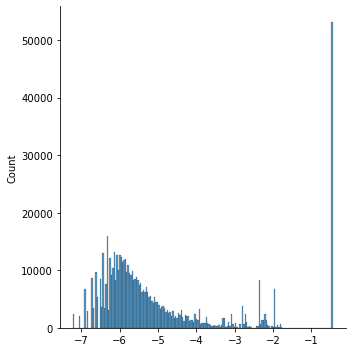

In [167]:
sns.displot(np.log10(human_botryllus_kmer_probs_adjusted))

In [174]:
groupby = ["name_query", "name_found"]
human_botryllus_kmer_probs_adjusted.name = "p_value_adjusted"
human_botryllus_kmer_probs.name = "p_value"

## Join with gather results

In [227]:
gather_results_human_with_probs = gather_results_human.join(
    human_botryllus_kmer_probs_adjusted, on=groupby
).join(human_botryllus_kmer_probs, on=groupby)
gather_results_human_with_probs["p_value_adjusted_log10"] = np.log10(
    gather_results_human_with_probs["p_value_adjusted"]
)
gather_results_human_with_probs["p_value_log10"] = np.log10(
    gather_results_human_with_probs["p_value"]
)
gather_results_human_with_probs

/Users/olgabot/opt/miniconda3/envs/botryllus/lib/python3.10/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,i_query,kmer_query,kmer_hp,hashval,name_query,i_found,kmer_found,name_found,n_kmers,intersect_bp,...,species,found_i,homolog_group,genomic_coord,all_homologs_found,transcript_id,p_value_adjusted,p_value,p_value_adjusted_log10,p_value_log10
0,150,YSFTLKDDTGEVVLDQWNKASLVP,hphphpppphphhhpphpphphhh,3018107519398277786,g25414.t1 frame:1,1238,PKISLRRSSLKYLGCRYSEIKPYG,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,...,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7,1.488056e-05,2.576282e-11,-4.827381,-10.589007
1,151,SFTLKDDTGEVVLDQWNKASLVPG,phphpppphphhhpphpphphhhh,1234479950528962468,g25414.t1 frame:1,1239,KISLRRSSLKYLGCRYSEIKPYGL,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,...,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7,1.488056e-05,2.576282e-11,-4.827381,-10.589007
2,152,FTLKDDTGEVVLDQWNKASLVPGK,hphpppphphhhpphpphphhhhp,2563348012698350512,g25414.t1 frame:1,1240,ISLRRSSLKYLGCRYSEIKPYGLD,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,...,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7,1.488056e-05,2.576282e-11,-4.827381,-10.589007
3,15,NFHVGVKFVSSPKRGGVSQYLKGI,phphhhphhpphpphhhpphhphh,1046426320533182525,g25414.t1 frame:1,576,SVQPIVKLVSTATTAPPSTAPSGP,ENST00000453269.7 gene_id=ENSG00000106290.15;t...,2,10,...,human,1,TAF6---Taf6,Chr7:100107070-100119858(-),False,ENST00000453269.7,3.788608e-05,6.559246e-11,-4.421520,-10.183146
4,16,FHVGVKFVSSPKRGGVSQYLKGIF,hphhhphhpphpphhhpphhphhh,2154375574397474662,g25414.t1 frame:1,577,VQPIVKLVSTATTAPPSTAPSGPG,ENST00000453269.7 gene_id=ENSG00000106290.15;t...,2,10,...,human,1,TAF6---Taf6,Chr7:100107070-100119858(-),False,ENST00000453269.7,3.788608e-05,6.559246e-11,-4.421520,-10.183146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,19,NSWIFQDSVVIDTNDIAAWLRNKL,pphhhppphhhpppphhhhhppph,2741191184754143198,g5107.t1 frame:1,355,ETLILDSNPLACDCRLLWVFRRRW,ENST00000561030.5 gene_id=ENSG00000169783.13;t...,3,15,...,human,1,LINGO1---Lingo1,Chr15:77613024-77820900(-),True,ENST00000561030.5,1.217223e-07,2.107388e-13,-6.914630,-12.676255
4,20,SWIFQDSVVIDTNDIAAWLRNKLN,phhhppphhhpppphhhhhppphp,312706106409923617,g5107.t1 frame:1,356,TLILDSNPLACDCRLLWVFRRRWR,ENST00000561030.5 gene_id=ENSG00000169783.13;t...,3,15,...,human,1,LINGO1---Lingo1,Chr15:77613024-77820900(-),True,ENST00000561030.5,1.217223e-07,2.107388e-13,-6.914630,-12.676255
5,21,WIFQDSVVIDTNDIAAWLRNKLNV,hhhppphhhpppphhhhhppphph,5902042603803971015,g5107.t1 frame:1,357,LILDSNPLACDCRLLWVFRRRWRL,ENST00000561030.5 gene_id=ENSG00000169783.13;t...,3,15,...,human,1,LINGO1---Lingo1,Chr15:77613024-77820900(-),True,ENST00000561030.5,1.217223e-07,2.107388e-13,-6.914630,-12.676255
6,57,HLFSDFFRHVRFRSFHDMALSRLR,phhpphhpphphpphpphhhpphp,2353047329972989606,g5107.t1 frame:1,230,KGVDTFLRRPNFTRATTVPLQTLS,ENST00000261584.9 gene_id=ENSG00000083093.10;t...,2,10,...,human,2,PALB2---Palb2,Chr16:23603162-23641357(-),False,ENST00000261584.9,6.086117e-08,1.053694e-13,-7.215660,-12.977285


In [228]:
gather_results_human_with_probs["containment_adjusted"] = (
    gather_results_human_with_probs.containment.divide(
        gather_results_human_with_probs.p_value_adjusted
    )
)
gather_results_human_with_probs["containment_adjusted_log10"] = np.log10(
    gather_results_human_with_probs["containment_adjusted"]
)
gather_results_human_with_probs.head()

,i_query,kmer_query,kmer_hp,hashval,name_query,i_found,kmer_found,name_found,n_kmers,intersect_bp,...,homolog_group,genomic_coord,all_homologs_found,transcript_id,p_value_adjusted,p_value,p_value_adjusted_log10,p_value_log10,containment_adjusted,containment_adjusted_log10
0,150,YSFTLKDDTGEVVLDQWNKASLVP,hphphpppphphhhpphpphphhh,3018107519398277786,g25414.t1 frame:1,1238,PKISLRRSSLKYLGCRYSEIKPYG,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,...,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7,0.000015,2.576282e-11,-4.827381,-10.589007,778.399154,2.891202
1,151,SFTLKDDTGEVVLDQWNKASLVPG,phphpppphphhhpphpphphhhh,1234479950528962468,g25414.t1 frame:1,1239,KISLRRSSLKYLGCRYSEIKPYGL,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,...,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7,0.000015,2.576282e-11,-4.827381,-10.589007,778.399154,2.891202
2,152,FTLKDDTGEVVLDQWNKASLVPGK,hphpppphphhhpphpphphhhhp,2563348012698350512,g25414.t1 frame:1,1240,ISLRRSSLKYLGCRYSEIKPYGLD,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,...,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7,0.000015,2.576282e-11,-4.827381,-10.589007,778.399154,2.891202
3,15,NFHVGVKFVSSPKRGGVSQYLKGI,phphhhphhpphpphhhpphhphh,1046426320533182525,g25414.t1 frame:1,576,SVQPIVKLVSTATTAPPSTAPSGP,ENST00000453269.7 gene_id=ENSG00000106290.15;t...,2,10,...,TAF6---Taf6,Chr7:100107070-100119858(-),False,ENST00000453269.7,0.000038,6.559246e-11,-4.421520,-10.183146,396.916111,2.598699
4,16,FHVGVKFVSSPKRGGVSQYLKGIF,hphhhphhpphpphhhpphhphhh,2154375574397474662,g25414.t1 frame:1,577,VQPIVKLVSTATTAPPSTAPSGPG,ENST00000453269.7 gene_id=ENSG00000106290.15;t...,2,10,...,TAF6---Taf6,Chr7:100107070-100119858(-),False,ENST00000453269.7,0.000038,6.559246e-11,-4.421520,-10.183146,396.916111,2.598699


In [229]:
gather_results_human_with_probs_dedup = gather_results_human_with_probs.drop_duplicates(
    ["name_query", "name_found"]
).drop(
    [
        "i_query",
        "i_found",
        "found_i",
    ],
    axis=1,
)
gather_results_human_with_probs_dedup

,kmer_query,kmer_hp,hashval,name_query,kmer_found,name_found,n_kmers,intersect_bp,containment,symbol,...,homolog_group,genomic_coord,all_homologs_found,transcript_id,p_value_adjusted,p_value,p_value_adjusted_log10,p_value_log10,containment_adjusted,containment_adjusted_log10
0,YSFTLKDDTGEVVLDQWNKASLVP,hphphpppphphhhpphpphphhh,3018107519398277786,g25414.t1 frame:1,PKISLRRSSLKYLGCRYSEIKPYG,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,0.011583,ASTN1,...,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7,1.488056e-05,2.576282e-11,-4.827381,-10.589007,778.399154,2.891202
3,NFHVGVKFVSSPKRGGVSQYLKGI,phphhhphhpphpphhhpphhphh,1046426320533182525,g25414.t1 frame:1,SVQPIVKLVSTATTAPPSTAPSGP,ENST00000453269.7 gene_id=ENSG00000106290.15;t...,2,10,0.015038,TAF6,...,TAF6---Taf6,Chr7:100107070-100119858(-),False,ENST00000453269.7,3.788608e-05,6.559246e-11,-4.421520,-10.183146,396.916111,2.598699
5,NFHVGVKFVSSPKRGGVSQYLKGI,phphhhphhpphpphhhpphhphh,1046426320533182525,g25414.t1 frame:1,SVQPIVKLVSTATTAPPSTAPSGP,ENST00000472509.5 gene_id=ENSG00000106290.15;t...,2,10,0.013793,TAF6,...,TAF6---Taf6,Chr7:100107070-100119858(-),False,ENST00000472509.5,3.788608e-05,6.559246e-11,-4.421520,-10.183146,364.067881,2.561182
7,NFHVGVKFVSSPKRGGVSQYLKGI,phphhhphhpphpphhhpphhphh,1046426320533182525,g25414.t1 frame:1,SVQPIVKLVSTATTAPPSTAPSGP,ENST00000452041.5 gene_id=ENSG00000106290.15;t...,2,10,0.015038,TAF6,...,TAF6---Taf6,Chr7:100107070-100119858(-),False,ENST00000452041.5,3.788608e-05,6.559246e-11,-4.421520,-10.183146,396.916111,2.598699
9,NFHVGVKFVSSPKRGGVSQYLKGI,phphhhphhpphpphhhpphhphh,1046426320533182525,g25414.t1 frame:1,SVQPIVKLVSTATTAPPSTAPSGP,ENST00000344095.8 gene_id=ENSG00000106290.15;t...,2,10,0.015038,TAF6,...,TAF6---Taf6,Chr7:100107070-100119858(-),False,ENST00000344095.8,3.788608e-05,6.559246e-11,-4.421520,-10.183146,396.916111,2.598699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,KNKKIKKKCKLCTNDEETLHHLYV,pppphppppphppppppphpphhh,11285409516946892144,g16170.t1 frame:1,QESKLESQKDLEEEEDEEVRRYIM,ENST00000491570.2 gene_id=ENSG00000117477.12;t...,3,15,0.027778,CCDC181,...,CCDC181---Ccdc181,Chr1:169394870-169462221(-),True,ENST00000491570.2,2.708322e-06,4.688939e-12,-5.567300,-11.328925,10256.453522,4.010997
12,KKCKLCTNDEETLHHLYVECETYN,pppphppppppphpphhhpppphp,16982669796827599844,g16170.t1 frame:1,QKETFTTEERKHLSKLMLESQEFD,ENST00000263035.9 gene_id=ENSG00000181192.12;t...,6,30,0.016304,DHTKD1,...,DHTKD1---Dhtkd1,Chr10:12068917-12123228(+),False,ENST00000263035.9,1.278084e-06,2.212758e-12,-5.893440,-11.655066,12756.862223,4.105744
0,NSWIFQDSVVIDTNDIAAWLRNKL,pphhhppphhhpppphhhhhppph,2741191184754143198,g5107.t1 frame:1,ETLILDSNPLACDCRLLWVFRRRW,ENST00000355300.7 gene_id=ENSG00000169783.13;t...,3,15,0.014925,LINGO1,...,LINGO1---Lingo1,Chr15:77613024-77820900(-),True,ENST00000355300.7,1.217223e-07,2.107388e-13,-6.914630,-12.676255,122618.198079,5.088555
3,NSWIFQDSVVIDTNDIAAWLRNKL,pphhhppphhhpppphhhhhppph,2741191184754143198,g5107.t1 frame:1,ETLILDSNPLACDCRLLWVFRRRW,ENST00000561030.5 gene_id=ENSG00000169783.13;t...,3,15,0.015267,LINGO1,...,LINGO1---Lingo1,Chr15:77613024-77820900(-),True,ENST00000561030.5,1.217223e-07,2.107388e-13,-6.914630,-12.676255,125426.248417,5.098388


### Write to file

In [234]:
gather_results_human_with_probs_dedup.to_parquet(
    os.path.join(
        outdir, "botryllus_gather_human_results_adjusted_by_kmer_probabilities.parquet"
    )
)

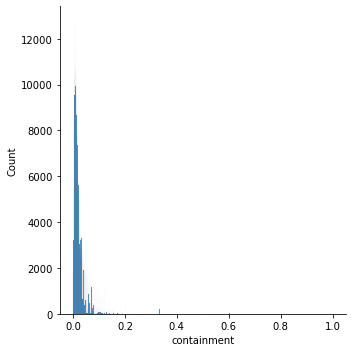

In [207]:
sns.displot(gather_results_human_with_probs_dedup.containment)

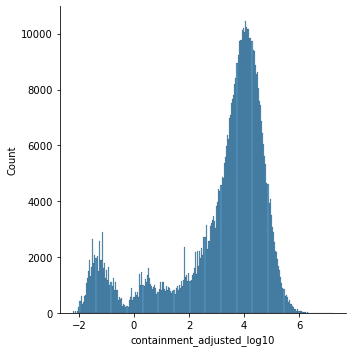

In [208]:
sns.displot(gather_results_human_with_probs_dedup.containment_adjusted_log10)

## What is the bump under log(containment_adjusted) = 0 = ? These are false positives right?

In [214]:
"p_value_adjusted	p_value	containment_adjusted	containment_adjusted_log10".split()

['p_value_adjusted',
 'p_value',
 'containment_adjusted',
 'containment_adjusted_log10']

In [223]:
cols = [
    "kmer_query",
    "kmer_found",
    "kmer_hp",
    # "hashval",
    "name_query",
    "symbol",
    "n_kmers",
    "intersect_bp",
    "p_value_adjusted",
    # "p_value",
    "containment",
    "containment_adjusted",
    "containment_adjusted_log10",
]

gather_results_human_with_probs_dedup.query("containment_adjusted < 1")[cols]

,kmer_query,kmer_found,kmer_hp,name_query,symbol,n_kmers,intersect_bp,p_value_adjusted,containment,containment_adjusted,containment_adjusted_log10
52,RRQGRKDRKQRHTTKRHRRREDRT,EQKAREEREREKEKEKERERERER,ppphpppppppppppppppppppp,g35044.t1 frame:1,RERE,13,65,0.010720,0.006024,0.561948,-0.250304
65,RRQGRKDRKQRHTTKRHRRREDRT,EQKAREEREREKEKEKERERERER,ppphpppppppppppppppppppp,g35044.t1 frame:1,RERE,13,65,0.010720,0.006024,0.561948,-0.250304
78,RRQGRKDRKQRHTTKRHRRREDRT,EQKAREEREREKEKEKERERERER,ppphpppppppppppppppppppp,g35044.t1 frame:1,RERE,8,40,0.010720,0.007435,0.693557,-0.158918
91,RRQGRKDRKQRHTTKRHRRREDRT,EQKAREEREREKEKEKERERERER,ppphpppppppppppppppppppp,g35044.t1 frame:1,RERE,8,40,0.010720,0.009804,0.914543,-0.038796
104,RRQGRKDRKQRHTTKRHRRREDRT,EEEAEDDEDEDDDEDDDDEDDDED,ppphpppppppppppppppppppp,g35044.t1 frame:1,CASZ1,7,35,0.010720,0.005797,0.540773,-0.266985
...,...,...,...,...,...,...,...,...,...,...,...
3217,EDEEEEEEDEDDEPDESNDDSEDD,SSSSSSSCSHSRSGSSSSSSSSCS,ppppppppppppphpppppppppp,g13530.t1 frame:1,CHD9,13,65,0.006164,0.005455,0.884940,-0.053086
3230,EDEEEEEEDEDDEPDESNDDSEDD,SSSSSSSCSHSRSGSSSSSSSSCS,ppppppppppppphpppppppppp,g13530.t1 frame:1,CHD9,13,65,0.006164,0.005415,0.878551,-0.056233
3589,EDEEEEEEDEDDEPDESNDDSEDD,SEKREEEEEEKEEFEEERSREEKR,ppppppppppppphpppppppppp,g13530.t1 frame:1,PIEZO2,4,20,0.003798,0.003724,0.980570,-0.008521
3925,DEDDEPDESNDDSEDDDDDDDEES,SSSSDAEESSEDNKKKKQRTSSKK,ppppphpppppppppppppppppp,g13530.t1 frame:1,ATRX,7,35,0.004382,0.004115,0.939218,-0.027234


In [225]:
gather_results_human_with_probs.query("containment_adjusted < 1").kmer_hp.value_counts()

pppppppppppppppppppppppp    6534053
hppppppppppppppppppppppp      85092
ppppppppppppppppppppppph      83561
pppppppppppppppppppppphp      53522
phpppppppppppppppppppppp      49063
                             ...   
hhpphpppppppppppppppphhp          1
phppphhhpppppppppppppppp          1
ppppphpphphppppphphppppp          1
pppppphpphphppppphphpppp          1
ppppphphphppphhppppppphp          1
Name: kmer_hp, Length: 2853, dtype: int64

### Check for TTN -> Likely false positive

In [231]:
gather_results_human_with_probs_dedup.query('symbol == "TTN"')

,kmer_query,kmer_hp,hashval,name_query,kmer_found,name_found,n_kmers,intersect_bp,containment,symbol,...,homolog_group,genomic_coord,all_homologs_found,transcript_id,p_value_adjusted,p_value,p_value_adjusted_log10,p_value_log10,containment_adjusted,containment_adjusted_log10
14,HKCDICWKTFSRNSSLKLHMQIHD,pppphphpphppppphphphphpp,9725064853951588524,g10767.t1 frame:1,SRTSLTIENANRNDSGKYTLTIQN,ENST00000342992.10 gene_id=ENSG00000155657.28;...,4,20,0.000305,TTN,...,TTN---Ttn,Chr2:178525989-178807423(-),False,ENST00000342992.10,1.186793e-05,2.054704e-11,-4.925625,-10.687251,25.657951,1.409222
18,HKCDICWKTFSRNSSLKLHMQIHD,pppphphpphppppphphphphpp,9725064853951588524,g10767.t1 frame:1,SRTSLTIENANRNDSGKYTLTIQN,ENST00000460472.6 gene_id=ENSG00000155657.28;t...,4,20,0.000375,TTN,...,TTN---Ttn,Chr2:178525989-178807423(-),False,ENST00000460472.6,1.186793e-05,2.054704e-11,-4.925625,-10.687251,31.576058,1.499358
22,HKCDICWKTFSRNSSLKLHMQIHD,pppphphpphppppphphphphpp,9725064853951588524,g10767.t1 frame:1,SRTSLTIENANRNDSGKYTLTIQN,ENST00000589042.5 gene_id=ENSG00000155657.28;t...,4,20,0.000287,TTN,...,TTN---Ttn,Chr2:178525989-178807423(-),False,ENST00000589042.5,1.186793e-05,2.054704e-11,-4.925625,-10.687251,24.202416,1.383859
26,HKCDICWKTFSRNSSLKLHMQIHD,pppphphpphppppphphphphpp,9725064853951588524,g10767.t1 frame:1,SRTSLTIENANRNDSGKYTLTIQN,ENST00000591111.5 gene_id=ENSG00000155657.28;t...,4,20,0.000296,TTN,...,TTN---Ttn,Chr2:178525989-178807423(-),False,ENST00000591111.5,1.186793e-05,2.054704e-11,-4.925625,-10.687251,24.929204,1.396708
30,HKCDICWKTFSRNSSLKLHMQIHD,pppphphpphppppphphphphpp,9725064853951588524,g10767.t1 frame:1,SRTSLTIENANRNDSGKYTLTIQN,ENST00000342175.11 gene_id=ENSG00000155657.28;...,4,20,0.000372,TTN,...,TTN---Ttn,Chr2:178525989-178807423(-),False,ENST00000342175.11,1.186793e-05,2.054704e-11,-4.925625,-10.687251,31.335333,1.496034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,YCKNKPYPKSRFCRGVPDPKIRIF,hpppphhhppphpphhhphphphh,15917872058373478622,g31704.t1 frame:1,VKTEEVVVKEDLQKPVLDLKLSGV,ENST00000359218.10 gene_id=ENSG00000155657.28;...,7,35,0.000373,TTN,...,TTN---Ttn,Chr2:178525989-178807423(-),True,ENST00000359218.10,1.704113e-06,2.950344e-12,-5.768502,-11.530127,218.757004,2.339962
42,GKPQGQVARVKIGQSIISIRCKDS,hphphphhphphhpphhphppppp,6145329843391584033,g31704.t1 frame:1,VTVNYEGISYKWLKNGVEIKSTDK,ENST00000360870.10 gene_id=ENSG00000155657.28;...,6,30,0.001784,TTN,...,TTN---Ttn,Chr2:178525989-178807423(-),True,ENST00000360870.10,1.704113e-06,2.950344e-12,-5.768502,-11.530127,1046.950334,3.019926
0,LQASPIKRTRSGSSDENLKVKINK,hphphhppppphppppphphphpp,6573107234909945976,g8341.t1 frame:1,ITVTWLKDSDEITEDDNIRMTFEN,ENST00000342992.10 gene_id=ENSG00000155657.28;...,3,15,0.000305,TTN,...,TTN---Ttn,Chr2:178525989-178807423(-),True,ENST00000342992.10,3.651670e-07,6.322165e-13,-6.437508,-12.199134,833.883401,2.921105
3,LQASPIKRTRSGSSDENLKVKINK,hphphhppppphppppphphphpp,6573107234909945976,g8341.t1 frame:1,ITVTWLKDSDEITEDDNIRMTFEN,ENST00000589042.5 gene_id=ENSG00000155657.28;t...,3,15,0.000287,TTN,...,TTN---Ttn,Chr2:178525989-178807423(-),True,ENST00000589042.5,3.651670e-07,6.322165e-13,-6.437508,-12.199134,786.578512,2.895742


### These plots take too long to make -> do in another notebook

In [232]:
# sns.jointplot(data=gather_results_human_with_probs_dedup, x='containment', y='p_value_adjusted_log10')

In [233]:
# sns.jointplot(data=gather_results_human_with_probs_dedup, x='containment', y='containment_adjusted_log10')

## Check BHF and HLA genes

In [246]:
bhf_hla = gather_results_human_with_probs.query(
    'name_query == "BHF" or symbol == "HLA"'
)
bhf_hla = bhf_hla.reset_index(drop=True)
bhf_hla

,i_query,kmer_query,kmer_hp,hashval,name_query,i_found,kmer_found,name_found,n_kmers,intersect_bp,...,homolog_group,genomic_coord,all_homologs_found,transcript_id,p_value_adjusted,p_value,p_value_adjusted_log10,p_value_log10,containment_adjusted,containment_adjusted_log10
0,101,LNASVEILSYFALWGFLRLAGMRI,hphphphhphhhhhhhhphhhhph,14727812379951326220,g24803.t1 frame:2,216,LKVSVSAVTLGLGLIIFSLGVISW,ENST00000418107.3 gene_id=ENSG00000242574.9;tr...,6,30,...,None,None,None,ENST00000418107.3,9.737787e-07,1.685911e-12,-6.011540,-11.773165,48901.305186,4.689320
1,102,NASVEILSYFALWGFLRLAGMRIT,phphphhphhhhhhhhphhhhphp,12122782715747205387,g24803.t1 frame:2,217,KVSVSAVTLGLGLIIFSLGVISWR,ENST00000418107.3 gene_id=ENSG00000242574.9;tr...,6,30,...,None,None,None,ENST00000418107.3,9.737787e-07,1.685911e-12,-6.011540,-11.773165,48901.305186,4.689320
2,103,ASVEILSYFALWGFLRLAGMRITC,hphphhphhhhhhhhphhhhphpp,731582254459325854,g24803.t1 frame:2,218,VSVSAVTLGLGLIIFSLGVISWRR,ENST00000418107.3 gene_id=ENSG00000242574.9;tr...,6,30,...,None,None,None,ENST00000418107.3,9.737787e-07,1.685911e-12,-6.011540,-11.773165,48901.305186,4.689320
3,104,SVEILSYFALWGFLRLAGMRITCF,phphhphhhhhhhhphhhhphpph,9470123982851188374,g24803.t1 frame:2,219,SVSAVTLGLGLIIFSLGVISWRRA,ENST00000418107.3 gene_id=ENSG00000242574.9;tr...,6,30,...,None,None,None,ENST00000418107.3,9.737787e-07,1.685911e-12,-6.011540,-11.773165,48901.305186,4.689320
4,105,VEILSYFALWGFLRLAGMRITCFL,hphhphhhhhhhhphhhhphpphh,1731407111791498839,g24803.t1 frame:2,220,VSAVTLGLGLIIFSLGVISWRRAG,ENST00000418107.3 gene_id=ENSG00000242574.9;tr...,6,30,...,None,None,None,ENST00000418107.3,9.737787e-07,1.685911e-12,-6.011540,-11.773165,48901.305186,4.689320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1730,181,SRESIEDKMRKFEIRSGPVSVRFG,pppphppphpphphpphhhphphh,12416047036496989669,g31557.t1 frame:1,110,QSEDGSHTLQRMSGCDLGPDGRLL,ENST00000383329.7 gene_id=ENSG00000204525.17;t...,4,20,...,None,None,None,ENST00000383329.7,1.825835e-07,3.161083e-13,-6.738538,-12.500164,142258.342360,5.153078
1731,12,AHHAVNLILFLLGVIGAVVGSVAF,hpphhphhhhhhhhhhhhhhphhh,15104296473932249346,g25752.t1 frame:1,215,METLVCALGLAIGLVGFLVGTVLI,ENST00000229829.7 gene_id=ENSG00000204252.14;t...,4,20,...,None,None,None,ENST00000229829.7,2.434447e-05,4.214777e-11,-4.613600,-10.375225,2161.952440,3.334846
1732,13,HHAVNLILFLLGVIGAVVGSVAFA,pphhphhhhhhhhhhhhhhphhhh,14033411958121755007,g25752.t1 frame:1,216,ETLVCALGLAIGLVGFLVGTVLII,ENST00000229829.7 gene_id=ENSG00000204252.14;t...,4,20,...,None,None,None,ENST00000229829.7,2.434447e-05,4.214777e-11,-4.613600,-10.375225,2161.952440,3.334846
1733,14,HAVNLILFLLGVIGAVVGSVAFAI,phhphhhhhhhhhhhhhhphhhhh,2355909948748173298,g25752.t1 frame:1,217,TLVCALGLAIGLVGFLVGTVLIIM,ENST00000229829.7 gene_id=ENSG00000204252.14;t...,4,20,...,None,None,None,ENST00000229829.7,2.434447e-05,4.214777e-11,-4.613600,-10.375225,2161.952440,3.334846


### get dedup subset to plot containment

In [245]:
bhf_hla_dedup = gather_results_human_with_probs_dedup.query(
    'name_query == "BHF" or symbol == "HLA"'
)
bhf_hla_dedup = bhf_hla_dedup.reset_index(drop=True)
bhf_hla_dedup

,kmer_query,kmer_hp,hashval,name_query,kmer_found,name_found,n_kmers,intersect_bp,containment,symbol,...,homolog_group,genomic_coord,all_homologs_found,transcript_id,p_value_adjusted,p_value,p_value_adjusted_log10,p_value_log10,containment_adjusted,containment_adjusted_log10
0,LNASVEILSYFALWGFLRLAGMRI,hphphphhphhhhhhhhphhhhph,14727812379951326220,g24803.t1 frame:2,LKVSVSAVTLGLGLIIFSLGVISW,ENST00000418107.3 gene_id=ENSG00000242574.9;tr...,6,30,0.047619,HLA,...,None,None,None,ENST00000418107.3,9.737787e-07,1.685911e-12,-6.011540,-11.773165,48901.305186,4.689320
1,SIIVILSVGVLLMGWVESVAIWDL,phhhhhphhhhhhhhhpphhhhph,2428164539587205037,g35550.t1 frame:1,QGAALLQMLPLLWLLPHSWAVPEG,ENST00000395305.7 gene_id=ENSG00000204257.15;t...,3,15,0.066667,HLA,...,None,None,None,ENST00000395305.7,1.247654e-06,2.160073e-12,-5.903906,-11.665532,53433.621277,4.727815
2,GLLGLYFFLLLIIVIAEIAVGIWA,hhhhhhhhhhhhhhhhphhhhhhh,10049823512562290122,g31619.t1 frame:2,PIVGIVAGLVVLGAVVTGAVVAAV,ENST00000376861.5 gene_id=ENSG00000204642.14;t...,4,20,0.033333,HLA,...,None,None,None,ENST00000376861.5,8.412839e-04,1.456521e-09,-3.075057,-8.836683,39.621979,1.597936
3,GLLGLYFFLLLIIVIAEIAVGIWA,hhhhhhhhhhhhhhhhphhhhhhh,10049823512562290122,g31619.t1 frame:2,PIVGIVAGLVVLGAVVTGAVVAAV,ENST00000334668.8 gene_id=ENSG00000204642.14;t...,4,20,0.033333,HLA,...,None,None,None,ENST00000334668.8,8.412839e-04,1.456521e-09,-3.075057,-8.836683,39.621979,1.597936
4,GLLGLYFFLLLIIVIAEIAVGIWA,hhhhhhhhhhhhhhhhphhhhhhh,10049823512562290122,g31619.t1 frame:2,PIVGIVAGLVVLGAVVTGAVVAAV,ENST00000259951.12 gene_id=ENSG00000204642.14;...,4,20,0.023810,HLA,...,None,None,None,ENST00000259951.12,8.412839e-04,1.456521e-09,-3.075057,-8.836683,28.301414,1.451808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,QLLTLMDGLKQRAHVVIIGATNRP,phhphhphhppphphhhhhhppph,9758106767797781808,g27348.t1 frame:1,RLPEFADWAQEQGDAPAILFDKEF,ENST00000395303.7 gene_id=ENSG00000204257.15;t...,4,20,0.040816,HLA,...,None,None,None,ENST00000395303.7,3.164781e-06,5.479210e-12,-5.499656,-11.261282,12897.047522,4.110490
357,QLLTLMDGLKQRAHVVIIGATNRP,phhphhphhppphphhhhhhppph,9758106767797781808,g27348.t1 frame:1,RLPEFADWAQEQGDAPAILFDKEF,ENST00000374843.9 gene_id=ENSG00000204257.15;t...,4,20,0.037037,HLA,...,None,None,None,ENST00000374843.9,3.164781e-06,5.479210e-12,-5.499656,-11.261282,11702.876455,4.068293
358,LPKSRESIEDKMRKFEIRSGPVSV,hhppppphppphpphphpphhhph,17238667430134878404,g31557.t1 frame:1,YYNQSEDGSHTLQRMSGCDLGPDG,ENST00000376228.9 gene_id=ENSG00000204525.17;t...,4,20,0.026316,HLA,...,None,None,None,ENST00000376228.9,1.825835e-07,3.161083e-13,-6.738538,-12.500164,144130.162654,5.158755
359,LPKSRESIEDKMRKFEIRSGPVSV,hhppppphppphpphphpphhhph,17238667430134878404,g31557.t1 frame:1,YYNQSEDGSHTLQRMSGCDLGPDG,ENST00000383329.7 gene_id=ENSG00000204525.17;t...,4,20,0.025974,HLA,...,None,None,None,ENST00000383329.7,1.825835e-07,3.161083e-13,-6.738538,-12.500164,142258.342360,5.153078


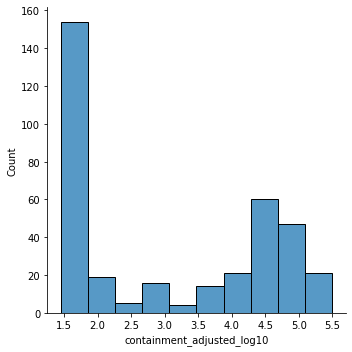

In [242]:
sns.displot(bhf_hla_dedup.containment_adjusted_log10)

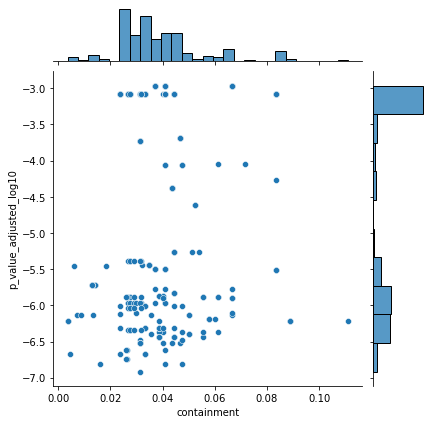

In [247]:
sns.jointplot(data=bhf_hla_dedup, x="containment", y="p_value_adjusted_log10")

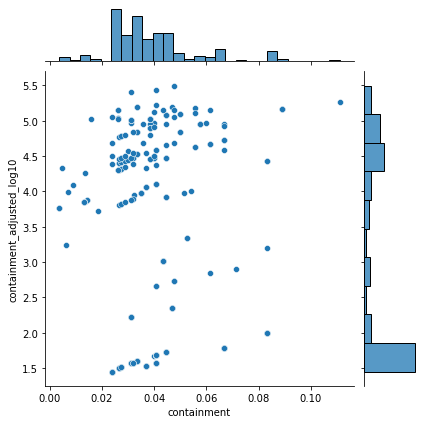

In [248]:
sns.jointplot(data=bhf_hla_dedup, x="containment", y="containment_adjusted_log10")

In [235]:
bhf_hla.query("containment_adjusted_log10 > 2 and intersect_bp >= 20").groupby(
    "name_query"
).symbol.unique()

name_query
BHF                  [ORC2, BMP3, ZNF292, RSF1, PNN, RNMT, ACE2]
g1026.t1 frame:1                                           [HLA]
g10843.t1 frame:1                                          [HLA]
g10991.t1 frame:1                                          [HLA]
g11020.t1 frame:1                                          [HLA]
g11327.t1 frame:2                                          [HLA]
g12132.t1 frame:1                                          [HLA]
g13184.t1 frame:1                                          [HLA]
g13388.t1 frame:1                                          [HLA]
g14365.t1 frame:1                                          [HLA]
g14791.t1 frame:1                                          [HLA]
g14922.t1 frame:3                                          [HLA]
g15686.t1 frame:1                                          [HLA]
g16495.t1 frame:1                                          [HLA]
g17720.t1 frame:1                                          [HLA]
g18286.t1 fram

In [255]:
bhf = bhf_hla.query('name_query == "BHF"')

In [256]:
bhf.to_clipboard(sep="\t")

## Remove duplicates

In [261]:
len("hhpphhphhphppppppppppphhppppp")

29

In [262]:
bhf_per_position = bhf.drop_duplicates(["i_query", "symbol"]).sort_values("i_query")
bhf_per_position

,i_query,kmer_query,kmer_hp,hashval,name_query,i_found,kmer_found,name_found,n_kmers,intersect_bp,...,homolog_group,genomic_coord,all_homologs_found,transcript_id,p_value_adjusted,p_value,p_value_adjusted_log10,p_value_log10,containment_adjusted,containment_adjusted_log10
947,37,IFCRILTALHLKKRRTEHDHQKLL,hhpphhphhphppppppppppphh,10240013254256923235,BHF,604,PLRRLGRPPKITTTNENQKTNTVA,ENST00000369577.8 gene_id=ENSG00000188994.13;t...,6,30,...,ZNF292---Zfp292,Chr6:87155551-87264172(+),False,ENST00000369577.8,6.086117e-07,1.053694e-12,-6.215660,-11.977285,5899.762493,3.770835
948,38,FCRILTALHLKKRRTEHDHQKLLS,hpphhphhphppppppppppphhp,8047764348242702868,BHF,605,LRRLGRPPKITTTNENQKTNTVAK,ENST00000369577.8 gene_id=ENSG00000188994.13;t...,6,30,...,ZNF292---Zfp292,Chr6:87155551-87264172(+),False,ENST00000369577.8,6.086117e-07,1.053694e-12,-6.215660,-11.977285,5899.762493,3.770835
949,39,CRILTALHLKKRRTEHDHQKLLSE,pphhphhphppppppppppphhpp,1452226584929511062,BHF,606,RRLGRPPKITTTNENQKTNTVAKQ,ENST00000369577.8 gene_id=ENSG00000188994.13;t...,6,30,...,ZNF292---Zfp292,Chr6:87155551-87264172(+),False,ENST00000369577.8,6.086117e-07,1.053694e-12,-6.215660,-11.977285,5899.762493,3.770835
950,40,RILTALHLKKRRTEHDHQKLLSES,phhphhphppppppppppphhppp,16483354457599739342,BHF,607,RLGRPPKITTTNENQKTNTVAKQE,ENST00000369577.8 gene_id=ENSG00000188994.13;t...,6,30,...,ZNF292---Zfp292,Chr6:87155551-87264172(+),False,ENST00000369577.8,6.086117e-07,1.053694e-12,-6.215660,-11.977285,5899.762493,3.770835
951,41,ILTALHLKKRRTEHDHQKLLSESQ,hhphhphppppppppppphhpppp,14855361501953140786,BHF,608,LGRPPKITTTNENQKTNTVAKQEQ,ENST00000369577.8 gene_id=ENSG00000188994.13;t...,6,30,...,ZNF292---Zfp292,Chr6:87155551-87264172(+),False,ENST00000369577.8,6.086117e-07,1.053694e-12,-6.215660,-11.977285,5899.762493,3.770835
952,42,LTALHLKKRRTEHDHQKLLSESQE,hphhphppppppppppphhppppp,791636867468234754,BHF,609,GRPPKITTTNENQKTNTVAKQEQR,ENST00000369577.8 gene_id=ENSG00000188994.13;t...,6,30,...,ZNF292---Zfp292,Chr6:87155551-87264172(+),False,ENST00000369577.8,6.086117e-07,1.053694e-12,-6.215660,-11.977285,5899.762493,3.770835
983,45,LHLKKRRTEHDHQKLLSESQEHLD,hphppppppppppphhpppppphp,1686103030246593445,BHF,97,AEGNSKKRKRETEDVPKDKSSTGD,ENST00000543302.6 gene_id=ENSG00000101654.18;t...,8,40,...,RNMT---Rnmt,Chr18:13726647-13764556(+),False,ENST00000543302.6,3.651670e-06,6.322165e-12,-5.437508,-11.199134,9552.813106,3.980131
984,46,HLKKRRTEHDHQKLLSESQEHLDA,phppppppppppphhpppppphph,8604508405379832510,BHF,98,EGNSKKRKRETEDVPKDKSSTGDG,ENST00000543302.6 gene_id=ENSG00000101654.18;t...,8,40,...,RNMT---Rnmt,Chr18:13726647-13764556(+),False,ENST00000543302.6,3.651670e-06,6.322165e-12,-5.437508,-11.199134,9552.813106,3.980131
985,47,LKKRRTEHDHQKLLSESQEHLDAS,hppppppppppphhpppppphphp,14278411361845042710,BHF,99,GNSKKRKRETEDVPKDKSSTGDGT,ENST00000543302.6 gene_id=ENSG00000101654.18;t...,8,40,...,RNMT---Rnmt,Chr18:13726647-13764556(+),False,ENST00000543302.6,3.651670e-06,6.322165e-12,-5.437508,-11.199134,9552.813106,3.980131
943,47,LKKRRTEHDHQKLLSESQEHLDAS,hppppppppppphhpppppphphp,14278411361845042710,BHF,328,PEKSKNKKKQRKGPHRKSQTLQFD,ENST00000282701.4 gene_id=ENSG00000152785.8;tr...,4,20,...,BMP3---Bmp3,Chr4:81030778-81057531(+),False,ENST00000282701.4,3.469086e-06,6.006057e-12,-5.459785,-11.221411,5338.154172,3.727391


In [271]:
def single_stitch_together_kmers(kmer_series):
    # stitched = ''
    for i, kmer in enumerate(kmer_series):
        if i == 0:
            stitched = kmer
        else:
            stitched += kmer[-1]
    return stitched


def stitch_together_species_hp_kmers(
    df,
    kmer_query="kmer_query",
    kmer_hp="kmer_hp",
    kmer_found="kmer_found",
    i_query="i_query",
):
    df = df.sort_values(i_query)
    query_stitched = single_stitch_together_kmers(df[kmer_query])
    hp_stitched = single_stitch_together_kmers(df[kmer_hp])
    found_stitched = single_stitch_together_kmers(df[kmer_found])
    start = df.i_query.min()
    end = start + len(found_stitched)
    to_print = (
        f"botryllus: {query_stitched}\nhp: {hp_stitched}\nhuman: {found_stitched}"
    )
    return pd.Series([start, end, to_print], index=["start", "end", "matches"])


bhf_per_position_matches = (
    bhf_per_position.groupby("symbol")
    .apply(stitch_together_species_hp_kmers)
    .sort_values(["start", "end"])
)
bhf_per_position_matches

,start,end,matches
symbol,,,
ZNF292,37,66,botryllus: IFCRILTALHLKKRRTEHDHQKLLSESQE\nhp: ...
RNMT,45,76,botryllus: LHLKKRRTEHDHQKLLSESQEHLDASTKKTK\nhp...
BMP3,47,74,botryllus: LKKRRTEHDHQKLLSESQEHLDASTKK\nhp: hp...
CFAP43,48,74,botryllus: KKRRTEHDHQKLLSESQEHLDASTKK\nhp: ppp...
PNN,70,102,botryllus: STKKTKKKAKKDKRKNKPPKKDSETSKPAQTT\nh...
RSF1,74,102,botryllus: TKKKAKKDKRKNKPPKKDSETSKPAQTT\nhp: p...
ACE2,96,125,botryllus: KPAQTTISRLPSNRNNNNANSFATTYEKF\nhp: ...
CACNA1G,128,153,botryllus: SLCSVDLIPVDIEFWDMENEPVDQL\nhp: phpp...
ORC2,165,194,botryllus: DDRFGERLIDRAQNKYAPLDEKQRSESHG\nhp: ...


In [276]:
bhf_per_position_matches.to_clipboard()

In [275]:
for gene, row in bhf_per_position_matches.iterrows():
    print(f"\n{gene} {row.start}-{row.end} aa")
    print(row.matches)


ZNF292 37-66 aa
botryllus: IFCRILTALHLKKRRTEHDHQKLLSESQE
hp: hhpphhphhphppppppppppphhppppp
human: PLRRLGRPPKITTTNENQKTNTVAKQEQR

RNMT 45-76 aa
botryllus: LHLKKRRTEHDHQKLLSESQEHLDASTKKTK
hp: hphppppppppppphhpppppphphpppppp
human: AEGNSKKRKRETEDVPKDKSSTGDGTQNKRK

BMP3 47-74 aa
botryllus: LKKRRTEHDHQKLLSESQEHLDASTKK
hp: hppppppppppphhpppppphphpppp
human: PEKSKNKKKQRKGPHRKSQTLQFDEQT

CFAP43 48-74 aa
botryllus: KKRRTEHDHQKLLSESQEHLDASTKK
hp: ppppppppppphhpppppphphpppp
human: RKQHEKSQTSEAVRKSREDLDVCKEH

PNN 70-102 aa
botryllus: STKKTKKKAKKDKRKNKPPKKDSETSKPAQTT
hp: pppppppphpppppppphhpppppppphhppp
human: RDRKHRRSVDRKRRDTSGLERSHKSSKGGSSR

RSF1 74-102 aa
botryllus: TKKKAKKDKRKNKPPKKDSETSKPAQTT
hp: pppphpppppppphhpppppppphhppp
human: HKRRLSSSESEESYLSKNSEDDELAKES

ACE2 96-125 aa
botryllus: KPAQTTISRLPSNRNNNNANSFATTYEKF
hp: phhppphpphhppppppphpphhpphpph
human: QALQQNGSSVLSEDKSKRLNTILNTMSTI

CACNA1G 128-153 aa
botryllus: SLCSVDLIPVDIEFWDMENEPVDQL
hp: phpphphhhhphphhphppphhpph
human: SLEHPTIPLAEMEA